## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import shutil
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
import tensorflow as tf 
from tensorflow import keras
import pandas as pd

In [3]:
#to save model in h5 format 
!pip install pyyaml h5py 

## Preprocessing 

In [3]:
#mount google drive, going to end up saving all np files to google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#check how many slides there are 
#it seems as if there are 21 pairs and two directories -> 44 total 
slides_folder = '/content/drive/My Drive/slides'

slides = os.listdir(slides_folder)
print(len(slides))

44


In [5]:
# create training set with this data first 

#retrieve mask and slide pairs 
slide_paths = [] 
mask_paths = [] 

for slide in slides: 
  #assign mask and slide respectively 
  if "tif" in slide:
    if "mask" in slide: 
      mask_paths.append(slide)
    else:
      slide_paths.append(slide)

#check that each slide has a mask 
for slide in slide_paths: 
  assoc_mask_path = slide[:-4] + "_mask.tif"
  if assoc_mask_path not in mask_paths: 
    print(slide)

In [6]:
# from the code above it seems that slide tumor_038 does not have a mask so we have to discard it 

#slide_paths.remove("tumor_038.tif")
print(len(slide_paths))
print(len(mask_paths))

#match up the slide and mask paths and check 
slide_paths.sort() 
mask_paths.sort()

print(slide_paths[15])
print(mask_paths[15])

21
21
tumor_084.tif
tumor_084_mask.tif


In [7]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [8]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [9]:
# initialize pos/neg patches folders 

pos_directory = "/content/drive/My Drive/slides/pos_patches/"
neg_directory = "/content/drive/My Drive/slides/neg_patches/"

In [10]:
#this method is used to get the patch in a certain level given the center of a patch in zoom level 0 

def get_patch_from_center(level, center, patch_size, slide):
  #center is saved in terms of zoom level 0 
  ds_factor = 2**level

  #we need to go back to the left hand corner 
  x_diff = (patch_size // 2) * ds_factor
  y_diff = (patch_size // 2) * ds_factor 

  x_corner = center[0] - x_diff
  y_corner = center[1] - y_diff 

  #now that we have the right endpoints, we can find the new patch but still centered on the same center 
  patch = read_slide(slide, x_corner, y_corner, level, patch_size, patch_size)
  return patch 

In [11]:
#get each patch, determine whether to discard or not, then find label, save to google drive directories 

#in this method, we are saving patches from zoom levels 2, 3, and 7 with the same centers -> our model
#will have 3 zoom levels 

def split_pos_neg_patches(patch_size, level, slide, mask, higher_level): 

  pos_directory = "/content/drive/My Drive/slides/pos_patches/"
  neg_directory = "/content/drive/My Drive/slides/neg_patches/"

  #find the number of full patches 
  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]

  #factor by which to map coords to zoom level 0 
  ds_factor = 2**level 

  for i in range(num_patches[0]):
    for j in range(num_patches[1]):

      #get the patch first 
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

      #find tissue areas
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      #based on tissue percentage( > 25) decide if keep or discard 
      if percent_tissue > 25: 

        #decide label now by using mask patch 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)

        #find center patch of mask 
        mask_center = [((i*patch_size) + (patch_size//2)) * ds_factor, ((j*patch_size) + (patch_size//2)) * ds_factor]
        mask_patch = mask_patch[:,:,0]

        #writing names for the files of all patches to make it easy to save and load in 
        file = slide_paths[0][:-4] + '_patch_'+ str(i) + '_' + str(j) + '_level_' + str(level) + ".npy"
        higher_file = slide_paths[0][:-4] + '_patch_'+ str(i) + '_' + str(j) + '_level_' + str(higher_level) + ".npy"
        higher_file_third = slide_paths[0][:-4] + '_patch_'+ str(i) + '_' + str(j) + '_level_' + str(7) + ".npy"

        #if any region of the mask has a 1, can classify as cancerous 
        if np.sum(mask_patch) >= 1:  
          #save np array to image file 
          with open(pos_directory + file, 'wb') as f:
            np.save(f, patch)

          #in addition, save patch from a higher zoom level with the same center 
          higher_patch = get_patch_from_center(higher_level, mask_center, patch_size, slide)

          with open(pos_directory + higher_file, 'wb') as g:
            np.save(g, higher_patch)

          #in addition, save patch from zoom level 7 with the same center 
          higher_patch_third = get_patch_from_center(7, mask_center, patch_size, slide)

          with open(pos_directory + higher_file_third, 'wb') as l:
            np.save(l, higher_patch_third)

        else: 
          #classify as negative label 
          with open(neg_directory + file, 'wb') as h:
            np.save(h, patch)

          #in addition, save patch from a higher zoom level with the same center 
          higher_patch = get_patch_from_center(higher_level, mask_center, patch_size, slide)

          with open(neg_directory + higher_file, 'wb') as k:
            np.save(k, higher_patch)

          #in addition, save patch from zoom level 7 with the same center 
          higher_patch_third = get_patch_from_center(7, mask_center, patch_size, slide)

          with open(neg_directory + higher_file_third, 'wb') as m:
            np.save(m, higher_patch_third)


  return None 

In [14]:
#choosing slides 10-18 to retrieve patches from (chosen because they have a reasonable number of positive patches)

for i in range(10, 18): 
  slide_path = slides_folder + "/" + slide_paths[i]
  mask_path = slides_folder + "/" + mask_paths[i]

  slide = open_slide(slide_path)
  mask = open_slide(mask_path) 

  split_pos_neg_patches(299, 3, slide, mask, 2)
  print("done for one slide")

done for one slide
done for one slide
done for one slide
done for one slide
done for one slide
done for one slide
done for one slide
done for one slide


In [15]:
#load in the numpy patches from google drive 

#separate patches by zoom level and cancerous/non-cancerous (zoom level specified in filename)
pos_level2 = [] 
neg_level2 = []
pos_level3 = [] 
neg_level3 = [] 
pos_level7 = []
neg_level7 = [] 

for name in os.listdir(pos_directory):
  pos_img = np.load(pos_directory + name)
  if name[-5] == '2':
    pos_level2.append(pos_img)
  elif name[-5] == '3':
    pos_level3.append(pos_img)
  elif name[-5] == '7':
    pos_level7.append(pos_img)

for name in os.listdir(neg_directory):
  neg_img = np.load(neg_directory + name)
  if name[-5] == '2':
    neg_level2.append(neg_img)
  elif name[-5] == '3':
    neg_level3.append(neg_img)
  elif name[-5] == '7':
    neg_level7.append(neg_img)

In [18]:
#As seen from this check, it is a very unbalanced dataset, therefore, the next step will be 
#to balance this dataset. 

#Just from zoom level 2, there are three times as many negative patches as positive patches 

print("Positive Total:", len(os.listdir(pos_directory)))
print("Negative Total:", len(os.listdir(neg_directory)))
print()
print("Positive Level 2:", len(pos_level2))

print("Negative Level 2:", len(neg_level2))

Positive Total: 1296
Negative Total: 3579

Positive Level 2: 432
Negative Level 2: 1193


In [72]:
#concatenate each zoom level pos+neg patches 
#create y dataset with labels 

#only keep as many negatives as positives 
level2_np_arrays = np.concatenate([np.stack(neg_level2[:432], axis=0), np.stack(pos_level2, axis=0)], axis=0)
level3_np_arrays = np.concatenate([np.stack(neg_level3[:432], axis=0), np.stack(pos_level3, axis=0)], axis=0)
level7_np_arrays = np.concatenate([np.stack(neg_level7[:432], axis=0), np.stack(pos_level7, axis=0)], axis=0)

testing_y = [0 for i in range(432)] + [1 for i in range(432)]
testing_y = np.asarray(testing_y)

print(level2_np_arrays.shape)
print(testing_y.shape)

(864, 299, 299, 3)
(864,)


## Model Creation

In [73]:
#generate model with three different zoom levels, concatenating three different models, one for each zoom level

def gen_model(patch_size):

  base_model_1 = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
                                                include_top=False,
                                                weights='imagenet') 
  
  base_model_2 = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
                                                include_top=False,
                                                weights='imagenet') 
  
  base_model_3 = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
                                                include_top=False,
                                                weights='imagenet') 

  base_model_1.trainable = False
  base_model_2.trainable = False 
  base_model_3.trainable = False

  global_average_layer_1 = tf.keras.layers.GlobalAveragePooling2D()
  
  global_average_layer_2 = tf.keras.layers.GlobalAveragePooling2D()

  global_average_layer_3 = tf.keras.layers.GlobalAveragePooling2D()

  input_1 = tf.keras.layers.Input(shape=(patch_size, patch_size, 3)) 
  input_2 = tf.keras.layers.Input(shape=(patch_size, patch_size, 3)) 
  input_3 = tf.keras.layers.Input(shape=(patch_size, patch_size, 3)) 

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_average_layer_1
  ])

  model_1 = model_1(input_1)

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_average_layer_2
  ])

  model_2 = model_2(input_2)

  model_3 = tf.keras.Sequential([
    base_model_3,
    global_average_layer_3
  ])

  model_3 = model_3(input_3)

  merged = tf.keras.layers.concatenate([model_1, model_2, model_3])
  prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

  model = tf.keras.models.Model(inputs=[input_1, input_2, input_3], outputs=prediction_layer)

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model 


In [74]:
model = gen_model(299)

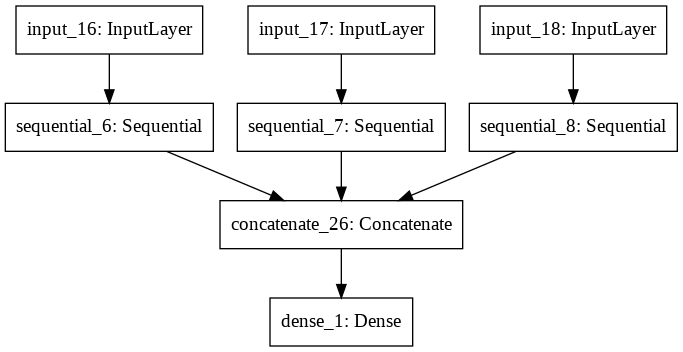

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [75]:
history = model.fit(x=[level2_np_arrays, level3_np_arrays, level7_np_arrays], y=testing_y, epochs=10, validation_split=0.2) 

Epoch 1/10
22/22 [==============================] - 489s 22s/step - loss: 7.9882 - accuracy: 0.5853 - val_loss: 5.3483 - val_accuracy: 0.5145
Epoch 2/10
22/22 [==============================] - 469s 22s/step - loss: 1.9793 - accuracy: 0.8014 - val_loss: 1.7165 - val_accuracy: 0.7283
Epoch 3/10
22/22 [==============================] - 474s 22s/step - loss: 0.8380 - accuracy: 0.8556 - val_loss: 2.5578 - val_accuracy: 0.6647
Epoch 4/10
22/22 [==============================] - 466s 21s/step - loss: 0.6352 - accuracy: 0.8578 - val_loss: 1.1869 - val_accuracy: 0.7514
Epoch 5/10
22/22 [==============================] - 474s 22s/step - loss: 0.4052 - accuracy: 0.8850 - val_loss: 0.4999 - val_accuracy: 0.8613
Epoch 6/10
22/22 [==============================] - 466s 21s/step - loss: 0.8383 - accuracy: 0.8386 - val_loss: 1.8147 - val_accuracy: 0.7225
Epoch 7/10
22/22 [==============================] - 467s 21s/step - loss: 0.3633 - accuracy: 0.9082 - val_loss: 1.3181 - val_accuracy: 0.7572
Epoch 

Highest Training Accuracy: 91.56% <br>
Highest Validation Accuracy: 90.71% 

In [76]:
#save model as checkpoint here 

model.save('my_first_model.h5')

## Testing Analysis

In [12]:
#load the model

model = keras.models.load_model("my_first_model.h5")

**Heatmap Generation**

In [22]:
#creating heatmaps on test slides 

def generate_heatmap(slide, mask, patch_size, model, level, level2):

  #get the number of patches in the slide 
  num_patches = [slide.level_dimensions[level][0]//patch_size, slide.level_dimensions[level][1]//patch_size]
  ds_factor = 2**level 

  y_test = [] #true values
  preds = []  #predicted values 
  whole_mask = [] 
  whole_slide = [] 

  for i in range(num_patches[0]):
    col_mask_patches = []
    slide_patches = [] 
    for j in range(num_patches[1]):
      #read the patch and then append to slide_patches (idea is to concatenate them into a row of patches)
      patch = read_slide(slide, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      slide_patches.append(patch)

      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = (len(tissue_pixels) / (patch_size * patch_size)) * 100

      mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
      mask_patch = mask_patch[:, :, 0]

      #need copy because actual mask is read only 
      mask_copy = np.zeros(mask_patch.shape)

      #only predict on patch if tissue percentage > 25
      if percent_tissue > 25: 
        mask_patch = read_slide(mask, i*patch_size*ds_factor, j*patch_size*ds_factor, level, patch_size, patch_size)
        mask_center = [((i*patch_size) + (patch_size//2)) * ds_factor, ((j*patch_size) + (patch_size//2)) * ds_factor]

        #reshape to fit into model 
        patch = np.expand_dims(patch, axis=0)
        
        #get the predictions from other zoom levels (2 and 7 in this case)
        higher_patch = get_patch_from_center(level2, mask_center, patch_size, slide)
        higher_patch = np.expand_dims(higher_patch, axis=0)
        higher_patch_third = get_patch_from_center(7, mask_center, patch_size, slide)
        higher_patch_third = np.expand_dims(higher_patch_third, axis=0)

        #get the prediction from all three patches combined 
        pred_1 = model.predict([higher_patch, patch, higher_patch_third])

        #final prediction is a probability for each class so have to round 
        final_pred = np.round(pred_1[0][0])
        preds.append(final_pred)

        #get actual answer from mask and add to y_test 
        if np.sum(mask_patch) >= 1: 
          y_test.append(1.0)
        else: 
          y_test.append(0.0)

        #color the mask in if it is predicted to be cancerous 
        if final_pred == 1.0: 
          mask_copy[0:patch_size, 0:patch_size] = 1

      col_mask_patches.append(mask_copy)

    #combine the row mask patches and slide patches 
    col_mask_patches = np.concatenate(col_mask_patches, axis=0)
    slide_patches = np.concatenate(slide_patches, axis = 0)
    whole_mask.append(col_mask_patches) 
    whole_slide.append(slide_patches)

  #combine all the column patches to create the whole mask and whole slide 
  whole_mask = np.concatenate(whole_mask, axis=1)
  whole_slide = np.concatenate(whole_slide, axis=1)
  return whole_slide, whole_mask, y_test, preds  


**Calculating Metrics**

In [14]:
#return the accuracy given the predicted and true values 
def accuracy(y_test, preds):
  count = 0 
  for i in range(len(y_test)):
    count += int(y_test[i] == preds[i])

  return count/len(y_test)

#return the precision, recall, and confusion matrix given the predicted and true values 
def precision_and_recall(y_test, preds):
  test_df_ratings = pd.DataFrame()
  test_df_ratings['prediction'] = preds
  test_df_ratings['actual'] = y_test

  #find count of true positive, true negative, etc...
  tp = 0
  fp = 0 
  fn = 0 
  tn = 0 
  for i in range(len(test_df_ratings)):
    if (test_df_ratings['actual'][i] == 1) &(test_df_ratings['prediction'][i] == 1):
      tp += 1
    elif (test_df_ratings['actual'][i] == 1) &(test_df_ratings['prediction'][i] == 0):
      fn += 1
    elif (test_df_ratings['actual'][i] == 0) &(test_df_ratings['prediction'][i] == 1):
      fp += 1
    elif (test_df_ratings['actual'][i] == 0) &(test_df_ratings['prediction'][i] == 0):
      tn += 1

  precision = tp / sum(test_df_ratings['prediction'])
  recall = tp / sum(test_df_ratings['actual'])

  #build confusion matrix 
  cf_matrix = pd.DataFrame() 
  cf_matrix['Actual_0'] = [tn, fp]
  cf_matrix['Actual_1'] = [fn, tp]

  return precision, recall, cf_matrix

In [15]:
#a few test slides I can evaluate model on 
test_slides = slide_paths[18:21]
test_masks = mask_paths[18:21]

#### First Test Slide Metrics/Analysis

In [19]:
#open the first test slide and test mask 
test_slide_1 = open_slide(slides_folder + "/" + slide_paths[7])
test_mask_1 = open_slide(slides_folder + "/" + mask_paths[7])

**Generated Heat Map from Model**

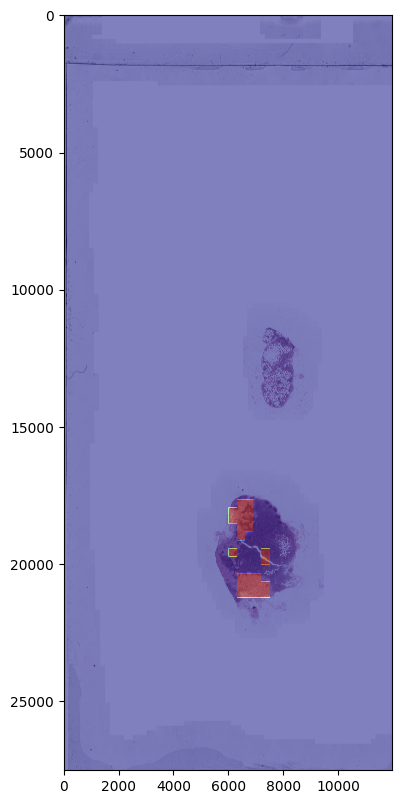

In [23]:
slide_map, mask_heatmap, y_test_ts1, preds_ts1 = generate_heatmap(test_slide_1, test_mask_1, 299, model, 3, 2)

#plot the heatmap 
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

**True Mask on Slide**

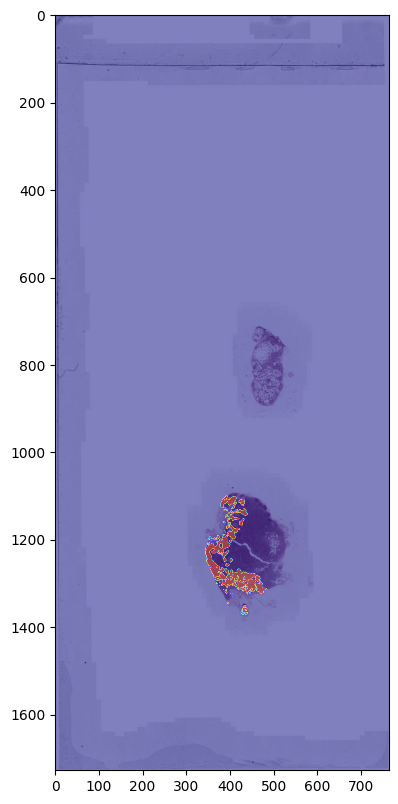

In [56]:
slide_image = read_slide(test_slide_1, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=test_slide_1.level_dimensions[7][0], 
                         height=test_slide_1.level_dimensions[7][1])


mask_image = read_slide(test_mask_1, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_1.level_dimensions[7][0], 
                        height=test_slide_1.level_dimensions[7][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

*Accuracy Metrics for Test Slide 1*

In [70]:
accuracy_ts_1 = accuracy(y_test_ts1, preds_ts1)
precision_ts_1, recall_ts_1, cf_matrix_ts_1 = precision_and_recall(y_test_ts1, preds_ts1)
print("Accuracy:", accuracy_ts_1)
print() 
print("Precision:", precision_ts_1)
print("Recall:", recall_ts_1)

cf_matrix_ts_1

Accuracy: 0.7222222222222222

Precision: 0.92
Recall: 0.3770491803278688


,Actual_0,Actual_1
0,81,38
1,2,23


 #### Second Test Slide Metrics/Analysis

**Generated HeatMap**

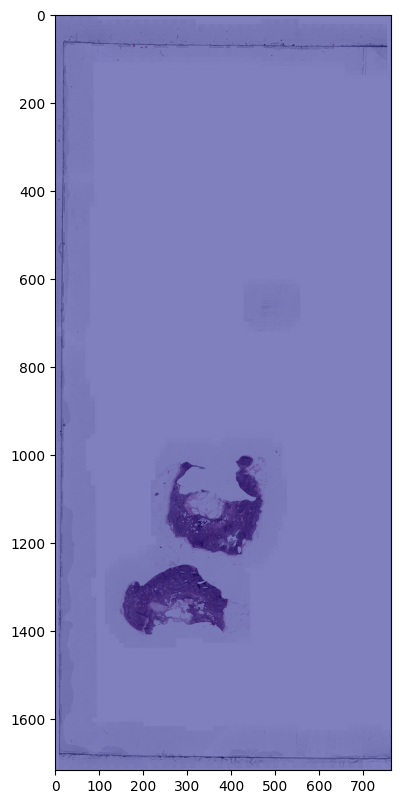

In [43]:
test_slide_2 = open_slide(slides_folder + "/" + slide_paths[2])
test_mask_2 = open_slide(slides_folder + "/" + mask_paths[2])

mask_heatmap, y_test_ts2, preds_ts2 = generate_heatmap(test_slide_2, test_mask_2, 299, model, 3, 2)
slide_map = read_slide(test_slide_2, 0, 0, 7, test_slide_2.level_dimensions[7][0], test_slide_2.level_dimensions[7][1]) 

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

**True Mask**

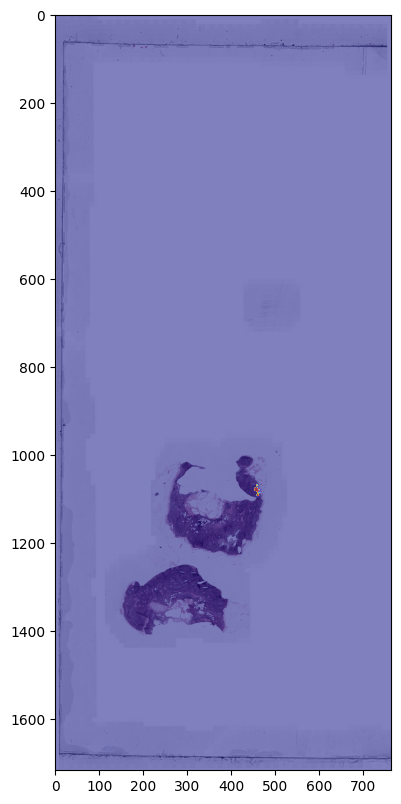

In [44]:
mask_image_2 = read_slide(test_mask_2, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_2.level_dimensions[7][0], 
                        height=test_slide_2.level_dimensions[7][1])

mask_image_2 = mask_image_2[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_image_2, cmap='jet', alpha=0.5) # Red regions contains cancer.

*Test Slide 2 Metrics*

In [45]:
accuracy_ts_2 = accuracy(y_test_ts2, preds_ts2)
precision_ts_2, recall_ts_2, cf_matrix_ts_2 = precision_and_recall(y_test_ts2, preds_ts2)
print("Accuracy:", accuracy_ts_2)
print() 
print("Precision:", precision_ts_2)
print("Recall:", recall_ts_2)

cf_matrix_ts_2

Accuracy: 0.9161676646706587

Precision: 0.0
Recall: 0.0


,Actual_0,Actual_1
0,153,2
1,12,0


#### Third Test Slide Metrics/Analysis

**Generated HeatMap from Model**

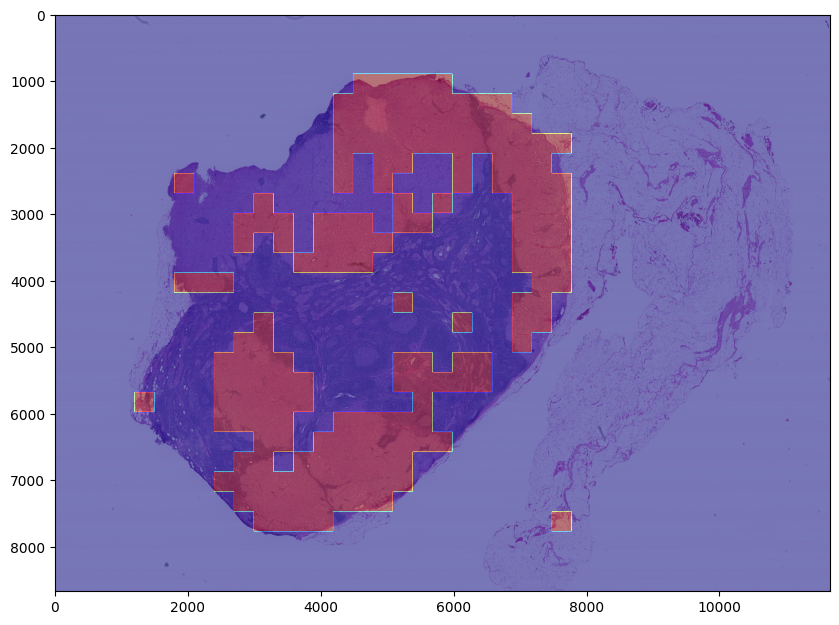

In [31]:
test_slide_3 = open_slide(slides_folder + "/" + test_slides[2])
test_mask_3 = open_slide(slides_folder + "/" + test_masks[2])

slide_map, mask_heatmap, y_test_ts3, preds_ts3 = generate_heatmap(test_slide_3, test_mask_3, 299, model, 3, 2)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

**True Mask on Test Slide 3**

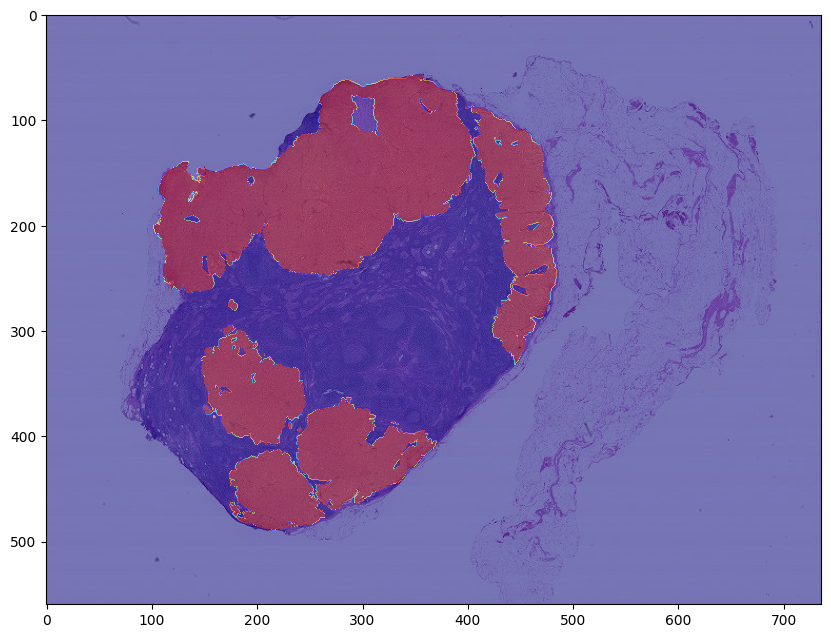

In [35]:
mask_image_3 = read_slide(test_mask_3, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide_3.level_dimensions[7][0], 
                        height=test_slide_3.level_dimensions[7][1])

mask_image_3 = mask_image_3[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_map)
plt.imshow(mask_image_3, cmap='jet', alpha=0.5) # Red regions contains cancer.

*Test Slide 3 Metrics*

In [36]:
accuracy_ts_3 = accuracy(y_test_ts3, preds_ts3)
precision_ts_3, recall_ts_3, cf_matrix_ts_3 = precision_and_recall(y_test_ts3, preds_ts3)
print("Accuracy:", accuracy_ts_3)
print() 
print("Precision:", precision_ts_3)
print("Recall:", recall_ts_3)

cf_matrix_ts_3

Accuracy: 0.7033248081841432

Precision: 0.9075144508670521
Recall: 0.6108949416342413


,Actual_0,Actual_1
0,118,100
1,16,157
